# IRL for PdN
- V.1.0 - 4-Aug-2024

In [1]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
# Custom libraries
from MT_environment import MillingTool_Env
from utilities import downsample, tool_wear_data

In [2]:
DATA_FILE = 'PHM_C01.csv'
WEAR_THRESHOLD = 0.12
SAMPLING_RATE = 20
ADD_NOISE = 0

EPISODES = 10_000
LOG_PATH = 'D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/'
# LOG_PATH = f'{PATH}/tensorboard/{now.strftime("%d-%b-%Y_%H_%M")}/'
writer = SummaryWriter(LOG_PATH)
print(f'Tensorboard logging to {LOG_PATH}')

Tensorboard logging to D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/


- Down-sampling. Input data records: 1000. Sampling rate: 20. Expected rows 50.    Down-sampled to 50 rows.


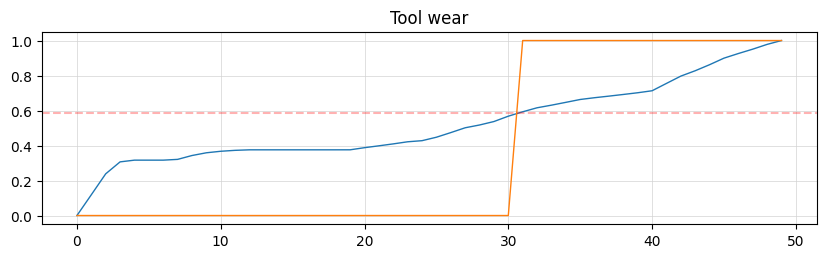

Tool failure RUL threshold at time 47 is 0.049


In [3]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MILLING_OPERATIONS_MAX = records

rul_threshold_record = int(0.95 * records)
rul_threshold = df_train.loc[df_train.index[rul_threshold_record], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record} is {rul_threshold:3.3f}')

In [4]:
from stable_baselines3.common.env_checker import check_env

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = MillingTool_Env,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

env_test = gym.make('custom/MillingToolEnv-v0', records=records, rul_threshold=rul_threshold)
# Check env. formation 
check_env(env_test)


 -- Milling tool environment initiatlized. Potential records 50. RUL threshold 0.049


In [5]:
env_test.tool_wear_data(df_train)


 - Milling tool environment: Tool wear data updated: 50


In [6]:
expert_ppo = PPO('MlpPolicy', env=env_test, tensorboard_log=LOG_PATH)
expert_ppo.learn(EPISODES)

PPO Expert reward: 132.000


In [7]:
expert_a2c = A2C('MlpPolicy', env=env_test, tensorboard_log=LOG_PATH)
expert_a2c.learn(EPISODES)

A2C Expert reward: 170.000


In [10]:
reward_ppo, _ = evaluate_policy(expert_ppo, env_test, 20)
print(f'PPO Expert reward: {reward_ppo:4.2f}')

reward_a2c, _ = evaluate_policy(expert_a2c, env_test, 20)
print(f'A2C Expert reward: {reward_a2c:4.2f}')

PPO Expert reward: 127.50
A2C Expert reward: 106.49
